<a href="https://colab.research.google.com/github/Yatz1403/NN-from-Scratch-with-numpy-and-math/blob/main/NNfromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'mnist-in-csv:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F27352%2F34877%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240307%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240307T210547Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1e079a102f4c9561dde65742dd251655a6bac2db9a585d6a04976756e74f0556dfbb7e2a654aa0288e997425a07d4c9778f0d80184a272bac469dd7740a4ef25b32fdd6138f285b4ed2fe88278eae3b79e5d5ac5cd616715d154d787d69c0f3e3c9557b7e85bf8f5e7c3a9366a24d79a134e5143142fc2d97de86a49c18c4b8a302c37123320c9dd3b816adbe9b4606a99384c4716597bed2ea95cf5370738b3f9f689160067014d6b610694863bd3196b7ad6c64ff0b4e5b1dfcb0f6c7abc24128e93574b41d211258685a1c3b796f2b16b26d57d69c4e32a3edfad489d8978d1f4114a8aa33594d87a84ef60d366589d15cc85fac874f906e0b658a31f28c5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
data = pd.read_csv('/kaggle/input/mnist-in-csv/mnist_train.csv')


In [ ]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape

In [ ]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

In [ ]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [ ]:
#testting
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
[9 5 9 ... 8 5 4] [8 4 0 ... 6 2 1]
0.0503728813559322
Iteration:  10
[9 0 8 ... 8 6 4] [8 4 0 ... 6 2 1]
0.09272881355932204
Iteration:  20
[2 0 0 ... 0 6 4] [8 4 0 ... 6 2 1]
0.144
Iteration:  30
[2 0 0 ... 0 6 4] [8 4 0 ... 6 2 1]
0.18652542372881356
Iteration:  40
[2 0 0 ... 0 6 0] [8 4 0 ... 6 2 1]
0.2333898305084746
Iteration:  50
[2 0 0 ... 0 6 0] [8 4 0 ... 6 2 1]
0.26457627118644067
Iteration:  60
[2 0 0 ... 8 6 0] [8 4 0 ... 6 2 1]
0.2945762711864407
Iteration:  70
[2 0 0 ... 1 6 1] [8 4 0 ... 6 2 1]
0.3418135593220339
Iteration:  80
[2 5 0 ... 1 6 1] [8 4 0 ... 6 2 1]
0.4286440677966102
Iteration:  90
[2 4 0 ... 1 6 1] [8 4 0 ... 6 2 1]
0.4976271186440678
Iteration:  100
[2 7 0 ... 1 0 1] [8 4 0 ... 6 2 1]
0.5414237288135593
Iteration:  110
[2 4 0 ... 7 0 1] [8 4 0 ... 6 2 1]
0.5750847457627118
Iteration:  120
[2 4 0 ... 7 0 1] [8 4 0 ... 6 2 1]
0.6029661016949153
Iteration:  130
[2 4 0 ... 7 0 1] [8 4 0 ... 6 2 1]
0.6274237288135593
Iteration:  140
[2 4 0 ... 

In [ ]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [8]
Label:  8


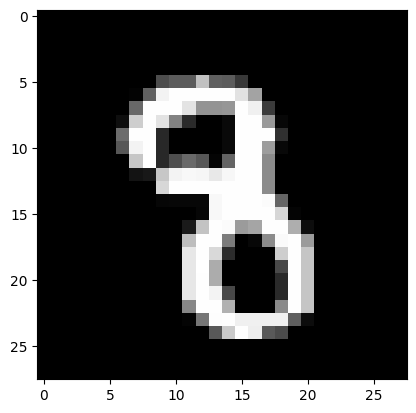

Prediction:  [4]
Label:  4


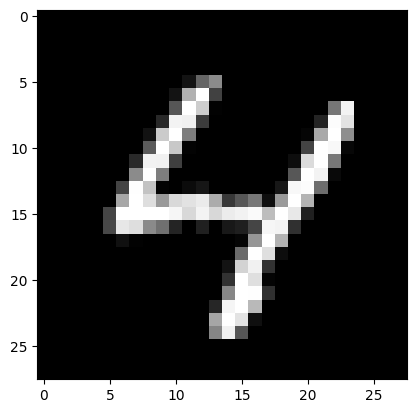

Prediction:  [0]
Label:  0


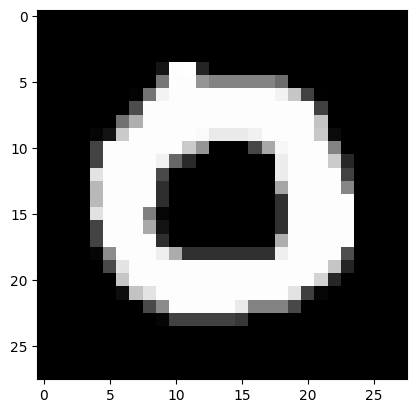

Prediction:  [5]
Label:  5


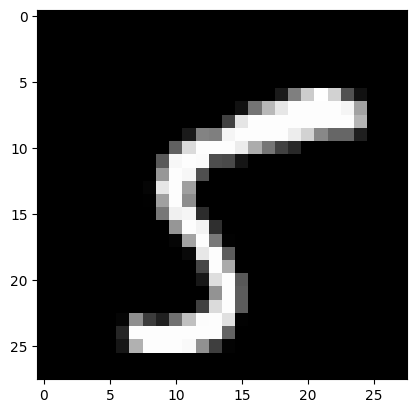

In [ ]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)